<ipython-input-1-0fc285b333fb>:88: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 172s 13s/step - accuracy: 0.5199 - loss: 8.0385 - val_accuracy: 0.7895 - val_loss: 4.0903 - learning_rate: 1.0000e-04
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7895 - val_loss: 4.0903 - learning_rate: 1.0000e-04
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 120s 12s/step - accuracy: 0.7746 - loss: 4.5489 - val_accuracy: 0.5263 - val_loss: 5.4145 - learning_rate: 1.0000e-04
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 639ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5263 - val_loss: 5.4145 - learning_rate: 1.0000e-04
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 117s 13s/step - accuracy: 0.7714 - loss: 4.8235 - val_accuracy: 0.8947 - val_loss: 3.4453 - learning_rate: 5.0000e-05
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8947 - val_loss: 3.4453 - learning_rate: 5.0000e-05
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 125s 13s/step - accuracy: 0.8935 - loss: 3.4479 - val_accuracy: 0.5263 - val_loss: 4.6123 - learning_rate: 5.0000e-05
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.000

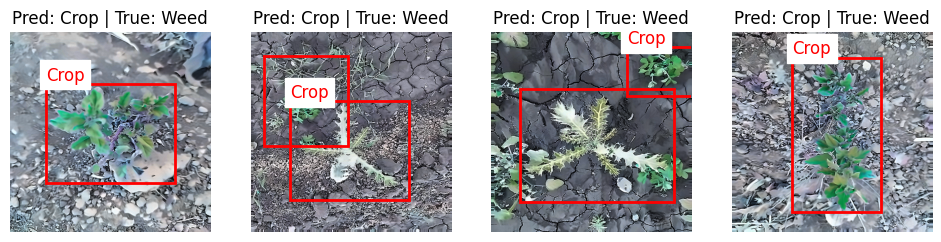

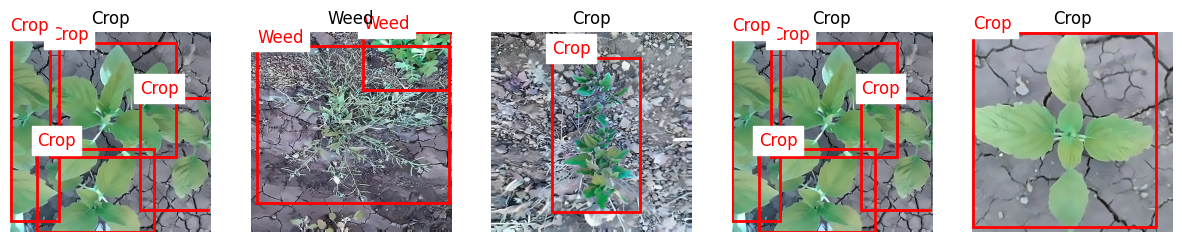

In [1]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_images_and_annotations(img_path, lab_path, img_size=(512, 512), denoise=False, sharpen=False):
    images = []
    labels = []
    bboxes = []

    for img_file in os.listdir(img_path):
        if img_file.endswith('.jpeg'):

            # Load and resize image

            img = cv2.imread(os.path.join(img_path, img_file))
            img = cv2.resize(img, img_size)
            if denoise:
                img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
            if sharpen:
                kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
                img = cv2.filter2D(img, -1, kernel)
            images.append(img)

            # Load corresponding label and bounding boxes from XML

            label_file = img_file.replace('.jpeg', '.xml')
            bbox, label = load_annotation_xml(os.path.join(lab_path, label_file))
            bboxes.append(bbox)
            labels.append(label[0])  

    return np.array(images), np.array(labels), bboxes


def load_annotation_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    bbox = []
    labels = []
    for obj in root.findall('object'):
        class_id = obj.find('name').text
        if class_id == 'weed':
            label = 1
        else:
            label = 0

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        bbox.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return bbox, labels

# Load the images and labels 
images, labels, bboxes = load_images_and_annotations("/content/drive/MyDrive/internship/new intern", "/content/drive/MyDrive/internship/annotations", denoise=True, sharpen=True)

# Normalize images
images = images / 255.0

X_train, X_test, y_train, y_test, bboxes_train, bboxes_test = train_test_split(images, labels, bboxes, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Unfreeze the last few layers of the base model for fine-tuning'

for layer in base_model.layers[-10:]:
    layer.trainable = True

# Added custom top layers for binary classification

x = Flatten()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate scheduler

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=8),
    steps_per_epoch=len(X_train) // 8,
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler]
)

# Evaluate the model

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy * 100, "%")

# Predict probabilities

y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels

y_pred = np.round(y_pred_prob).flatten()
misclassified_idx = np.where(y_pred != y_test)[0]

plt.figure(figsize=(15, 7))
for i in range(5):
    if i < len(misclassified_idx):
        idx = misclassified_idx[i]
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_test[idx])
        for bbox in bboxes_test[idx]:
            xmin, ymin, xmax, ymax = bbox
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', facecolor='none', linewidth=2))
        label = 'Weed' if y_pred[idx] == 1 else 'Crop'
        plt.text(xmin, ymin - 10, label, color='red', fontsize=12, backgroundcolor='white')
        plt.title(f"Pred: {label} | True: {'Weed' if y_test[idx] == 1 else 'Crop'}")
        plt.axis('off')
plt.show()

# Dsiplay the images with bounding boxes and labels

plt.figure(figsize=(15, 7))
for i in range(5):
    idx = random.randint(0, len(X_test) - 1)
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[idx])
    for bbox in bboxes_test[idx]:
        xmin, ymin, xmax, ymax = bbox
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', facecolor='none', linewidth=2))
        label = 'Weed' if y_pred[idx] == 1 else 'Crop'
        plt.text(xmin, ymin - 10, label, color='red', fontsize=12, backgroundcolor='white')
    plt.title(label)
    plt.axis('off')
plt.show()
